# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [9]:
from langchain.schema import AIMessage, HumanMessage

messages = [
    AIMessage(content=f"So you said you were researching Bengal tigers?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.", name="Kunal"))
messages.append(AIMessage(content=f"Great, what would you like to know about them?", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best places to see them in India.", name="Kunal"))


for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching Bengal tigers?
================================ Human Message =================================
Name: Kunal

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to know about them?
================================ Human Message =================================
Name: Kunal

I want to learn about the best places to see them in India.


In [10]:
import os, getpass
def _set_env_(api_key):
    if not os.environ.get(api_key):
        os.environ[api_key] = getpass.getpass(f"{api_key} : ")

_set_env_('GROQ_API_KEY')

In [11]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen-qwq-32b")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [12]:
result

AIMessage(content='\n<think>\nOkay, the user wants to know the best places in India to see Bengal tigers. Let me start by recalling the major tiger reserves in India. I know that India has several Project Tiger reserves, so those would be the top spots.\n\nFirst, Ranthambore National Park comes to mind because it\'s famous for its tigers and has a good track record of sightings. Then there\'s Bandhavgarh National Park, which I think has a high density of tigers. Pench and Kanha in Madhya Pradesh are also notable. Jim Corbett National Park in Uttarakhand is another key location. Sunderban National Park in West Bengal is unique because it\'s a mangrove habitat, though tiger sightings there might be different.\n\nI should list these parks with some details about each. Maybe mention their locations, best times to visit, and any unique features. It\'s important to highlight the best time for tiger sightings, which I believe is usually during the winter months when the weather is cooler and 

In [13]:
result.response_metadata

{'token_usage': {'completion_tokens': 1806,
  'prompt_tokens': 71,
  'total_tokens': 1877,
  'completion_time': 4.460667208,
  'prompt_time': 0.007403211,
  'queue_time': 0.23105369,
  'total_time': 4.468070419},
 'model_name': 'qwen-qwq-32b',
 'system_fingerprint': 'fp_512a3da6bb',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

In [17]:
def multipy(a: int, b: int) -> int:
    """ Multipy a and b.
    Agrs:
        a: first int
        b: first int 
    """
    return a*b

llm_with_tools = llm.bind_tools([multipy])

In [18]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Kunal")])

In [19]:
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_42pg', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multipy'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 242, 'prompt_tokens': 185, 'total_tokens': 427, 'completion_time': 0.610863832, 'prompt_time': 0.032366859, 'queue_time': 0.44546944200000005, 'total_time': 0.643230691}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_a91d9c2cfb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-92a8b77f-f267-4a10-8c04-f65ad2a3aa41-0', tool_calls=[{'name': 'multipy', 'args': {'a': 2, 'b': 3}, 'id': 'call_42pg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 185, 'output_tokens': 242, 'total_tokens': 427})

In [20]:
tool_call.tool_calls

[{'name': 'multipy',
  'args': {'a': 2, 'b': 3},
  'id': 'call_42pg',
  'type': 'tool_call'}]

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [22]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessageState(TypedDict):
    """Message state."""
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [ ]:
from typing_extensions import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    """Message state."""
    messages: Annotated[list[AnyMessage], add_messages]

In [29]:
from langgraph.graph import MessagesState

class MessageState(MessagesState):
    pass

In [30]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on Investment in India as AI sector is growing and i want to invest in publicly traded company on NSE.", name="Kunal")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that...", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='bd495048-044c-458c-85e1-d028be35ef27'),
 HumanMessage(content="I'm looking for information on Investment in India as AI sector is growing and i want to invest in publicly traded company on NSE.", additional_kwargs={}, response_metadata={}, name='Kunal', id='a4bb740c-dc47-483c-82f8-81e13a6913b3'),
 AIMessage(content='Sure, I can help with that...', additional_kwargs={}, response_metadata={}, name='Model', id='e6a9b5e5-b019-43fe-9668-c45beebeb55a')]

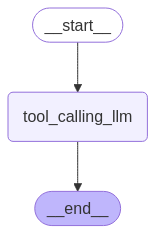

In [31]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [33]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multipy (call_3mse)
 Call ID: call_3mse
  Args:
    a: 2
    b: 3
